# 'AI' Tank Battle

Pythonスクリプトで戦車AIを書いてみます。

In [ ]:
# おまじない ... Python スクリプトを Run ボタンを押して次々に実行してみてください。
%load_ext processingpymat
%matplotlib nbagg

## 自機AIの定義

自分でAIの戦略を考えて実装してみましょう！

クラス名 `MyAI` として定義するようにしてください。

In [2]:
import math
from Tankgame.tankai import TankAI, Operation

class MyAI(TankAI):
    def __init__(self, name='Unknown'):
        super().__init__(name)
    
    def perform(self, env):
        op = Operation()
        live_enemies = [e for e in env.enemies if not e.dead]
        if len(live_enemies) == 0:
            # 1. 敵が見えない... 回りながら待機を続ける
            #op.key_turn_right = True
            # 自機が僚機の方向を向いていなければ撃つ
            to_buddy = False
            for buddy in env.buddies:
                # (1)自機からみて僚機がどの角度に位置しているかを計算
                dx = buddy.x - env.myself.x
                dy = buddy.y - env.myself.y
                buddy_angle = math.atan2(dy, dx) / math.pi * 180 # ラジアンから度に変換
                # (2)現在の角度との差分を計算
                # env.myself.body_rot が戦車の向いている角度 ... 0度ならばマップ右を向いている, +ならば時計回り方向, -ならば反時計回り
                # math.atan2で計算した角度とは符号を反転する(回転方向を逆にする)必要がある
                diff_angle = buddy_angle - env.myself.body_rot
                if abs(diff_angle) <= 45:
                    to_buddy = True
            if not to_buddy:
                # 僚機の方を向いていなければ撃つ
                op.key_shoot = True
            return op

        # 2. 敵が見える場合
        enemy = live_enemies[0]
        # 自機を敵の方へと向かせる
        # (1)自機からみて敵がどの角度に位置しているかを計算
        dx = enemy.x - env.myself.x
        dy = enemy.y - env.myself.y
        enemy_angle = math.atan2(dy, dx) / math.pi * 180 # ラジアンから度に変換

        # (2)現在の角度との差分を計算
        # env.myself.body_rot が戦車の向いている角度 ... 0度ならばマップ右を向いている, +ならば時計回り方向, -ならば反時計回り
        # math.atan2で計算した角度とは符号を反転する(回転方向を逆にする)必要がある
        diff_angle = enemy_angle - env.myself.body_rot
        if diff_angle < 0:
            op.key_turn_left = True
        elif diff_angle > 0:
            op.key_turn_right = True
        if abs(diff_angle) > 45:
            # 角度が一定以上ずれていたら進行はしない
            op.key_drive = False
            op.key_reverse = False
        print((self.name, env.myself.body_rot, enemy_angle, diff_angle))

        #  敵との距離を一定間隔に維持する
        dist = math.sqrt(dx * dx + dy * dy)
        if dist > 100:
            print(self.name, dist)
            op.key_drive = True
        elif dist < 50:
            op.key_reverse = True
        # 撃ち続ける
        op.key_shoot = True
        return op

## 敵AIの定義

クラス名 `EnemyAI` として定義するようにしてください。

敵AIはランダムに移動・撃つようなロジックにしています。

In [5]:
from Tankgame.tankai import TankAI, Operation

class EnemyAI(TankAI):
    def __init__(self, name='Random'):
        super().__init__(name)
        self.timer = 20
    
    def perform(self, env):
        op = Operation()
        op.key_aim_right = True
        op.key_drive = True
        op.key_shoot = True
        
        self.timer -= 1
        
        if self.timer <= 0:
            self.timer = int(random(10, 60))
            self._do_random(op)
    
        return op
    
    def _do_random(self, op):
        a = int(random(5))
        if a == 0:
            op.key_aim_right = True
            op.key_aim_left = False
        elif a == 1:
            op.key_aim_right = False
            op.key_aim_left = True
        elif a == 2:
            op.key_turn_right = True
            op.key_turn_left = False
        elif a == 3:
            op.key_turn_right = False
            op.key_turn_left = True
        elif a == 4:
            op.key_turn_right = False
            op.key_turn_left = False

# 戦闘実行

In [6]:
from Tankgame.tankai import Manager

manager = Manager()

def hero_AI(tank):
    return MyAI('Legion A')

def enemy_AI(tank):
    return EnemyAI('Legion B')

<IPython.core.display.Javascript object>


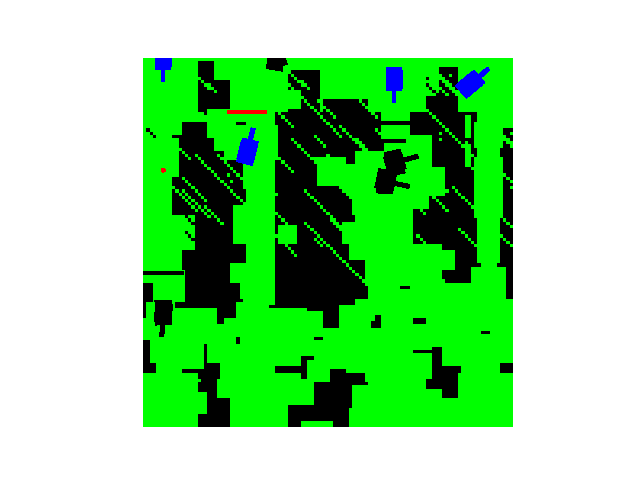

/srv/conda/envs/notebook/lib/python3.7/site-packages/processingpymat/processing.py:22: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])
/srv/conda/envs/notebook/lib/python3.7/site-packages/processingpymat/processing.py:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_yticks([], [])


(<processingpymat.processing.Processing at 0x7fbc03254110>,
 <matplotlib.animation.FuncAnimation at 0x7fbc044d5410>)

In [7]:
%%processing skipframes=9
import traceback
from Tankgame.env import Environment
from Tankgame.world import World
from Tankgame.tank import Tank
from Tankgame.target import Target
from Tankgame.ai import AI
from Tankgame.ui import UI

bullets = []

def setup():
    global grid, target, world, heroes, enemies, ui, hero_AIs, enemy_AIs

    size(460, 460, P2D)
    noSmooth()

    ui = UI()

    world = World(width, height, 4)
    world.create_grid()

    heroes = []
    hero_AIs = []
    for tankx in [30, width // 4 + 30, width // 4 * 3 - 30, width - 30]:
        tank = Tank(tankx, 30, bullets, ui, True)
        tank.body_rot = 90
        tank.gun_rot = 90
        world.destroy(70, tank.x, tank.y)
        heroes.append(tank)
        hero_AIs.append(hero_AI(tank))

    enemies = []
    enemy_AIs = []
    for tankx in [30, width // 4 + 30, width // 4 * 3 - 30, width - 30]:
        enemy = Tank(tankx, height - 30, bullets, ui, False)
        enemy.body_rot = -90
        enemy.gun_rot = -90
        world.destroy(70,  enemy.x, enemy.y)
        enemies.append(enemy)
        enemy_AIs.append(enemy_AI(enemy))

    noStroke()
    
    # Start game automatically
    ui.state = ui.gameplay


def draw():
    global bullets, world, heroes, enemies, ui

    #background(200, 255, 100)
    background(0, 255, 0)

    world.render()
    
    for tank, ai in zip(heroes, hero_AIs):
        if tank.dead:
            continue
        try:
            op = ai.perform(Environment(world, tank, heroes, enemies, bullets))
            op.applyTo(tank)
        except:
            textAlign(CENTER)
            fill(255)
            text('ERROR', tank.real_x, tank.real_y)
            traceback.print_exc()
            
    for tank, ai in zip(enemies, enemy_AIs):
        if tank.dead:
            continue
        try:
            op = ai.perform(Environment(world, tank, enemies, heroes, bullets))
            op.applyTo(tank)
        except:
            textAlign(CENTER)
            fill(255)
            text('ERROR', tank.real_x, tank.real_y)

    for tank in heroes:
        if ui.state == ui.gameplay:
            tank.update(world)
        tank.render(False)

    for enemy in enemies:
        if ui.state == ui.gameplay:
            enemy.update(world)
        enemy.render(False)

    destroyed = []
    for i, bullet in enumerate(bullets):

        destroy = False

        if bullet.x < 0 or bullet.x > width or bullet.y < 0 or bullet.y > height:
            destroy = True
        else:

            for tank in heroes:
                if bullet.x > tank.x-tank._height/2 and bullet.x < tank.x+tank._height/2 and bullet.y > tank.y-tank._height/2 and bullet.y < tank.y+tank._height/2:
                    tank.hit()
                    destroy = True
                    continue

            for enemy in enemies:

                if bullet.x > enemy.x-enemy._height/2 and bullet.x < enemy.x+enemy._height/2 and bullet.y > enemy.y-enemy._height/2 and bullet.y < enemy.y+enemy._height/2:
                    enemy.hit()
                    destroy = True
                    continue

            if world.grid[min(int(bullet.y / world.cell_size), len(world.grid) - 1)][min(int(bullet.x / world.cell_size), len(world.grid[0]) - 1)] == 1:

                world.destroy(int(random(20, 40)), int(bullet.x), int(bullet.y))
                destroy = True

        if destroy:
            destroyed.append(i)
            continue

        if ui.state == ui.gameplay:
            bullet.update()
        bullet.render()
        
    for d in destroyed[::-1]:
        bullets.pop(d)
    manager.log(world, heroes, enemies, bullets)

    ui.render()

## デバッグ

ユニットが ERROR となる場合は、自分のAIで何かプログラムのミスをしている可能性があります。
オフラインモードで実行すると、Tracebackが表示されるので原因追及に役立つかも！

In [ ]:
proc = %lastprocess
manager.reset()
proc.generate(frames=manager.get_frames, skipframes=59, debug=True)

<IPython.core.display.Javascript object>

Draw(frame=1, skipframe=0): duration=0.03431 seconds.
Draw(frame=1, skipframe=1): duration=0.03878 seconds.
Draw(frame=1, skipframe=2): duration=0.030119 seconds.
Draw(frame=1, skipframe=3): duration=0.022005 seconds.
Draw(frame=1, skipframe=4): duration=0.020337 seconds.
Draw(frame=1, skipframe=5): duration=0.020509 seconds.
Draw(frame=1, skipframe=6): duration=0.019207 seconds.
Draw(frame=1, skipframe=7): duration=0.021306 seconds.
Draw(frame=1, skipframe=8): duration=0.042039 seconds.
Draw(frame=1, skipframe=9): duration=0.040032 seconds.
Draw(frame=1, skipframe=10): duration=0.036375 seconds.
Draw(frame=1, skipframe=11): duration=0.258739 seconds.
Draw(frame=1, skipframe=12): duration=0.083605 seconds.
Draw(frame=1, skipframe=13): duration=0.05001 seconds.
Draw(frame=1, skipframe=14): duration=0.04274 seconds.
Draw(frame=1, skipframe=15): duration=0.049997 seconds.
Draw(frame=1, skipframe=16): duration=0.030914 seconds.
Draw(frame=1, skipframe=17): duration=0.030072 seconds.
Draw(f